In [1]:
from data_generators_torch import *
from train_torch import *
from tqdm import tqdm
import matplotlib.pyplot as plt

2.5.1+cu124


In [2]:
# Load the checkpointed state_dict
#checkpoint_dir = "/projects/bdoy/vsouzaramos/WaveNet_training_full_2channel_break/checkpoints/model_lre-3_epoch=69-val_loss=0.02986.ckpt"
#checkpoint_path = os.path.join(checkpoint_dir, 'model_lre-3_epoch=01-val_loss=0.00252.ckpt')
checkpoint_path = "/projects/bdoy/vsouzaramos/WaveNet_training_full_2channel_break/checkpoints/model_lre-3_epoch=69-val_loss=0.02986.ckpt"
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'] 
# Remove the "model." prefix from keys
print(checkpoint_path)
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("model."):
        new_key = key[len("model."):]  # Remove the "model." prefix
    else:
        new_key = key
    new_state_dict[new_key] = value
# Load the modified state_dict into the model
model = full_module()
model.load_state_dict(new_state_dict)

/projects/bdoy/vsouzaramos/WaveNet_training_full_2channel_break/checkpoints/model_lre-3_epoch=69-val_loss=0.02986.ckpt


/tmp/ipykernel_932186/210359701.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict']


<All keys matched successfully>

In [3]:
data_dir = "/scratch/bdao/victoria/WaveNet_data"
noise_dir = '/projects/bbvf/victoria/WaveNet_data/Gaussian_Noise/'
gaussian=1
train=1
batch_size=32
num_workers=8
n_channels=3
if train:
    wf_file = data_dir + '/combined_spin/train_300.hdf'
else:
    wf_file = data_dir + '/combined_spin/test_300.hdf'

In [4]:
data_module = WaveformDataModule(noise_dir, 
                                 data_dir, 
                                 batch_size=batch_size,
                                 n_channels=n_channels,
                                 gaussian=1,
                                 noise_prob=0.7, 
                                 noise_range=None, 
                                 num_workers=num_workers,
                                 )

In [5]:
data_module.setup()
val_dataset = data_module.val_dataset
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Limit DataLoader to first 5 batches
limited_loader = torch.utils.data.Subset(val_loader.dataset, range(5 * val_loader.batch_size))

# Create a DataLoader with the subset
limited_val_loader = DataLoader(limited_loader, batch_size=val_loader.batch_size, shuffle=False)

In [6]:
predictions = []
ground_truth = []
for inputs, targets in tqdm(limited_val_loader, desc="Validating", leave=True):
    with torch.no_grad():
        outputs = model(inputs)
    # Collect predictions and ground-truth labels
    predictions.append(outputs.detach().numpy())
    ground_truth.append(targets.detach().numpy())  # Access ground-truth labels

# Concatenate results into arrays
predictions = np.concatenate(predictions).squeeze(axis=-1)
ground_truth = np.concatenate(ground_truth).squeeze(axis=-1)


Validating:   0%|          | 0/5 [00:00<?, ?it/s]/u/vsouzaramos/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
Validating: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


In [7]:
print(predictions.shape)
print(ground_truth.shape)

(20, 4096)
(20, 4096)


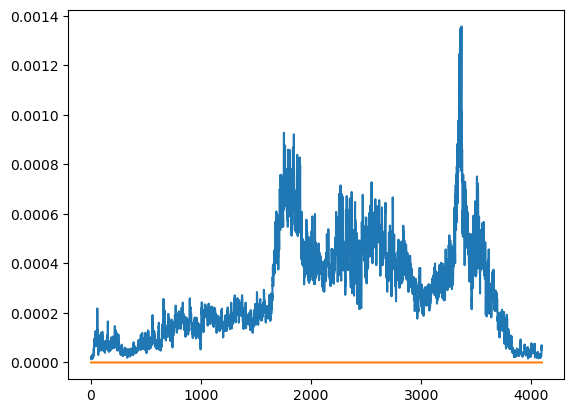

In [8]:
plt.plot(predictions[0,:])
plt.plot(ground_truth[0,:])

In [9]:
def FAR_sim(predictions, ground_truth, threshold):
    sample_rate = 4096  # Hz
    window_size = sample_rate  # 1 second = 4096 samples
    half_window = window_size // 2  # ±0.5s = 2048 samples, or half a second in each direction, following https://iopscience.iop.org/article/10.1088/0264-9381/33/21/215004/pdf

    if np.any(ground_truth) == 1:
        event_indices = np.where(ground_truth==1)[0] # indices of ground truth where an event exists
        for event_index in event_indices:
            start = max(0, event_index - half_window)  # Make sure start_idx is >= 0
            end = min(4096, event_index + half_window)  # Make sure end_idx is <= 4095
            max_pred = np.max(predictions[start:end])  # Highest detection score
            max_index = np.argmax(predictions[start:end]) + start  # Adjust index to full array
        
            # If the max prediction in the window is above the threshold, classify it as a detection
            if max_pred >= threshold:
                # Compute False Alarm Rate: How often did noise trigger a detection?
                false_alarms = np.sum((predictions >= threshold) & (ground_truth == 0))
                total_time_seconds = len(predictions) / sample_rate  # Convert samples to seconds
                far = false_alarms / total_time_seconds if total_time_seconds > 0 else 0

            else:
                far = 0  # No detection in the window

    else: # in case ground-truth is only zeros, anything above threshold is a false alarm
        # Count false positives: Predictions above threshold
        false_positives = np.sum(predictions >= threshold)

        # Total duration in seconds (number of samples / sampling rate)
        total_time_seconds = len(predictions) / sample_rate

        # FAR in Hz (false positives per second)
        far = false_positives / total_time_seconds

    return far

In [10]:
def FAR_sim(predictions, ground_truth, threshold):
    sample_rate = 4096  # Hz
    window_size = sample_rate  # 1 second = 4096 samples
    half_window = window_size // 2  # ±0.5s = 2048 samples

    if np.any(ground_truth):  # Check if there's any signal event
        event_indices = np.where(ground_truth == 1)[0]  # Indices where an event exists

        # Track valid detections within event windows
        detected_events = 0
        for event_index in event_indices:
            start = max(0, event_index - half_window)  # Ensure within bounds
            end = min(len(predictions), event_index + half_window)  # Ensure within bounds
            max_pred = np.max(predictions[start:end])  # Highest detection score in window
            
            # If any detection exceeds threshold within the event window, count as detected
            if max_pred >= threshold:
                detected_events += 1

        # False alarms: Predictions above threshold that are **not within any event window**
        false_alarms = np.sum((predictions >= threshold) & (ground_truth == 0))

    else:  # No true events, all high predictions are false alarms
        false_alarms = np.sum(predictions >= threshold)

    # Compute FAR over the entire duration
    total_time_seconds = len(predictions) / sample_rate
    far = false_alarms / total_time_seconds if total_time_seconds > 0 else 0

    return far


In [13]:
thresholds = np.linspace(0.1,1,5)
FARs = []

for index in range(len(predictions)):
    prediction_FARs=[]
    for threshold in thresholds:
        prediction_FARs.append(FAR_sim(predictions[index], ground_truth[index], threshold))
    FARs.append(prediction_FARs)

FARs = np.stack(FARs)
print(FARs)

[[  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [ 86.  11.   2.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [ 49.   2.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [161.  60.  18.  14.   0.]
 [  0.   0.   0.   0.   0.]
 [138.  20.   2.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [110.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.]]


In [31]:
tFARs = np.logspace(-1,4,100) # list of threshold FARs for the plot

sens_vols = []
for threshold_index in range(len(thresholds)):
    detections_for_this_threshold=[]
    for tFAR in tFARs:
        good_detections =  np.sum(FARs[:, threshold_index] < tFAR)
        detections_for_this_threshold.append(good_detections)
    sens_vols.append(detections_for_this_threshold)

#print(sens_vols)
sens_vols = np.stack(sens_vols)
print(sens_vols.shape)

(5, 100)


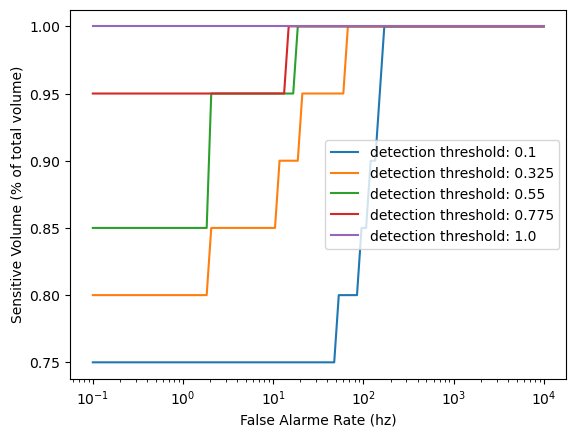

In [32]:
fig,ax=plt.subplots()
ax.set_xscale("log")
ax.set_xlabel("False Alarme Rate (hz)")
ax.set_ylabel("Sensitive Volume (% of total volume)")
for t in range(len(sens_vols)):
    ax.plot(tFARs, sens_vols[t]/len(FARs), label =f"detection threshold: {thresholds[t]}")
ax.legend()
